In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
#获取投资组合股票收盘价
symbols = ['AAPL','YHOO','MSFT','DB','GLD']
df = pd.DataFrame()
for sym in symbols:
    df[sym] = AAPL = get_pricing(sym,start_date='2014-01-03', end_date='2017-12-30',frequency='daily',handle_missing='raise')['close_price']
df.columns=symbols    
df.head()

,AAPL,YHOO,MSFT,DB,GLD
2014-01-03 00:00:00+00:00,71.660,40.12,33.305,45.953,119.31
2014-01-06 00:00:00+00:00,72.045,39.93,32.593,46.267,119.52
2014-01-07 00:00:00+00:00,71.526,40.89,32.836,47.328,118.82
2014-01-08 00:00:00+00:00,71.984,41.03,32.250,48.476,118.14
2014-01-09 00:00:00+00:00,71.058,40.92,32.042,48.418,118.45


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-03 to 2017-12-29
Freq: C
Data columns (total 5 columns):
AAPL    1006 non-null float64
YHOO    1006 non-null float64
MSFT    1006 non-null float64
DB      1006 non-null float64
GLD     1006 non-null float64
dtypes: float64(5)
memory usage: 47.2 KB


In [4]:
returns = df.pct_change().dropna()*252
returns.head()

,AAPL,YHOO,MSFT,DB,GLD
2014-01-06 00:00:00+00:00,1.353893,-1.193420,-5.387299,1.721933,0.443550
2014-01-07 00:00:00+00:00,-1.815365,6.058603,1.878808,5.778892,-1.475904
2014-01-08 00:00:00+00:00,1.613623,0.862803,-4.497259,6.112576,-1.442181
2014-01-09 00:00:00+00:00,-3.241720,-0.675603,-1.625302,-0.301510,0.661249
2014-01-10 00:00:00+00:00,-1.680993,1.909091,3.696398,5.928126,3.935838


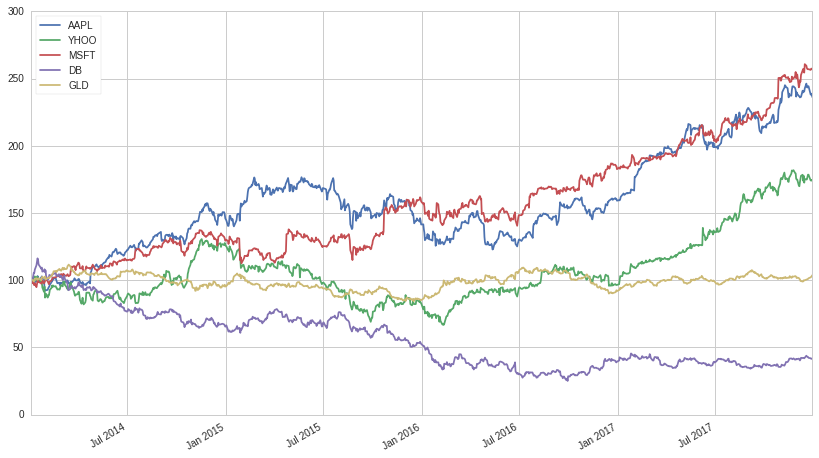

In [5]:
#将个股价格与其初始值比较并且用100标准化，得出个股在相同初始条件的情况下的走势情况。
(df/df.ix[0]*100).plot()

#初步统计分析

现在需要计算个股的收益率。金融计算收益率的时候大部分用对数收益率 (Log Return) 而不是用算数收益率。用当天的收盘价与前一天相比较
先转化为年化收益率，去252个交易日。并去NA

In [6]:
log_returns = np.log(df / df.shift(1)).dropna()
log_returns.head()
#看看前五行

,AAPL,YHOO,MSFT,DB,GLD
2014-01-06 00:00:00+00:00,0.005358,-0.004747,-0.021610,0.006810,0.001759
2014-01-07 00:00:00+00:00,-0.007230,0.023758,0.007428,0.022673,-0.005874
2014-01-08 00:00:00+00:00,0.006383,0.003418,-0.018007,0.023967,-0.005739
2014-01-09 00:00:00+00:00,-0.012947,-0.002685,-0.006471,-0.001197,0.002621
2014-01-10 00:00:00+00:00,-0.006693,0.007547,0.014562,0.023252,0.015498


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1ddf2bb50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff1caa7d490>]], dtype=object)

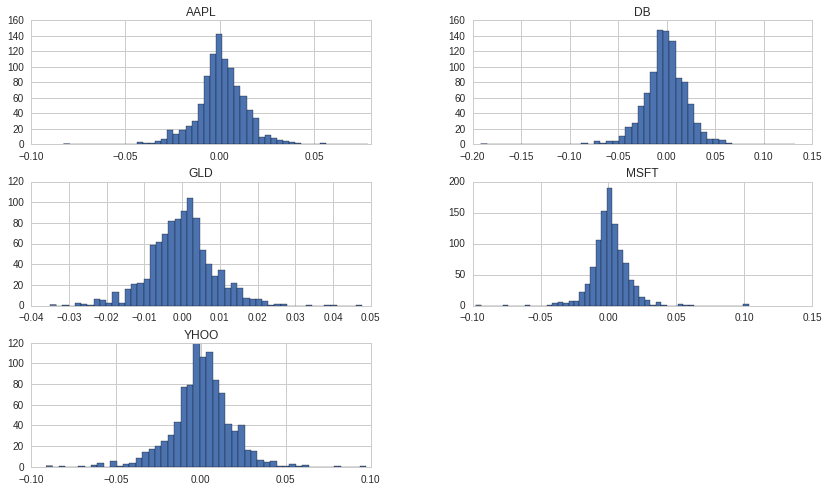

In [7]:
#画出每只股票收益率的直方图
log_returns.hist(bins=50)

有点正太分布的味道

# 投资组合优化

In [8]:
#使用对数收益率为收益率
returns = log_returns
#计算年化收益率
year_ret = returns.mean() * 252
#计算协方差矩阵
year_volatility = returns.cov() * 252

- 投资组合均值收益率公式：

$$E(r_p) = \sum_i^n{w_iE(r_i)} = w^T\mu$$

 - 投资组合波动情况

$$\sigma_p = \sum_{i,j=1}^n{w_iw_jE(r_i)} = w^T\Sigma  w$$

假设有5000组投资组合，每一组投资组合由一组随机权重组成，则可以这样产生5000组投资组合

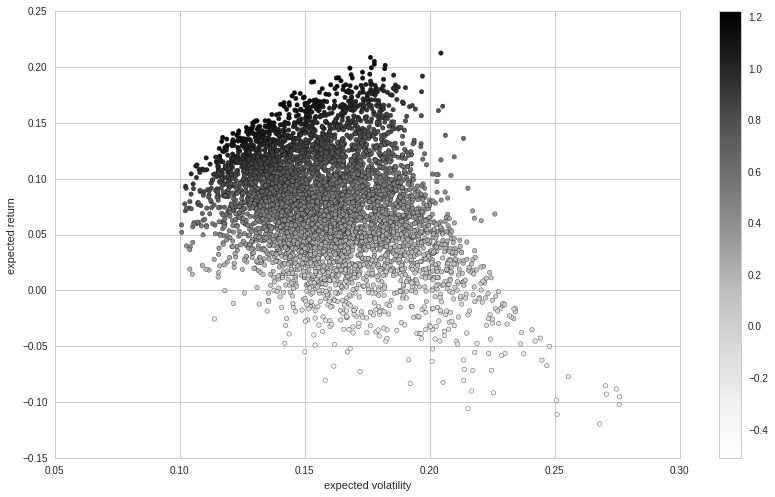

In [9]:
prets = []
pvols = [] 
for i in range(5000):
    w = np.random.rand(returns.shape[1],1)
    w/=np.sum(w)
    prets.append(np.sum(w.T.dot(returns.mean()))*252)
    pvols.append(np.sqrt(np.dot(w.T, 
                np.dot(returns.cov() * 252, w))))
prets = np.array(prets)
pvols = np.array(pvols).flatten()
plt.scatter(pvols,prets,c=prets/pvols,marker='o')
plt.xlabel('expected volatility') 
plt.ylabel('expected return') 
plt.colorbar()
plt.show()

每个点对应某个投资组合，该点有其对应的收益率和波动率（标准差），其颜色为对应的夏普率

我们现在再描述一下某个投资组合。这个投资组合是这样的一个函数，即输入权重分配，输出该组合的收益率、波动率和夏普率

In [10]:
def statistics(weights,returns): 
    '''Returns portfolio statistics. 

    Parameters 
    =============          
    weights:array-like 
    weights for different securities in portfolio 

    returns
    =============
    pret:float
    expexted portfolio daily return
    pvol:float
    expexted portfolio volatility 
    '''
    weights = np.array(weights)
    pret = np.sum(weights.T.dot(returns.mean()))*252
    pvol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return pret,pvol,np.float(pret/pvol)
def min_func_sharpe(weights,returns):
    return -statistics(weights,returns)[2]

*假设某投资组合的那个点的夏普率最高，即可认为该组合是夏普率最优的投资组合。夏普率最优的那个点不一定是刚才5000个点里面的其中一个，而是需要通过优化算法，找到一个恰当的权重分配输入，导致输出的夏普率最大。*

In [11]:
#引入了优化算法包
from scipy.optimize import minimize

In [12]:
#约束条件
cons = ({'type': 'eq',
          'fun' : lambda x: np.sum(x)-1       
        })
#边界条件
bounds = tuple((0, 1) for x in range(returns.shape[1])) 
w0 = [1.0/returns.shape[1]]*returns.shape[1]
opt_sharpe = minimize(min_func_sharpe,w0,method='SLSQP',bounds=bounds,constraints =cons,args=(returns,))

In [13]:
#最大夏普率权重分配，以及对应的组合收益率，波动率，sharpe_ratio
opt_sharpe['x'].round(3),statistics(opt_sharpe['x'],returns)

(array([ 0.321,  0.002,  0.469,  0.   ,  0.208]),
 (0.18241306189978646, 0.14779196205843903, 1.2342556344685225))

- 结论：假定最大夏普率的风险投资组合是最优风险风险投资组合。由股池，AAPL 	YHOO 	MSFT 	DB 	GLD，
对应权重分别文30.1%,4.2%,0%,23.9%,根据以往数据，可以分析得出组合年化收益率为18%，波动率为14.7%，夏普率为1.23。

#最小方差的投资组合，函数：

In [14]:
def min_func_variance(weights,returns):
    return statistics(weights,returns)[1] ** 2

In [15]:
opt_v = minimize(min_func_variance,w0,method='SLSQP',bounds=bounds,constraints=cons,args=(returns,))
#最小波动权重分配，以及对应的组合收益率，波动率，sharpe_ratio
opt_v['x'].round(3),statistics(opt_v['x'],returns)

(array([ 0.126,  0.055,  0.14 ,  0.07 ,  0.609]),
 (0.057953724525325462, 0.099230158025172294, 0.5840333793545305))

#有效边界

有效边界上的每一个点即为给定收益率情况下拥有最小波动率的投资组合的点.所以计算有效边界上的点，可以描述成，已知该点的收益率，求权重组合，使得该点波动率最小。

In [16]:
def min_func_vol(weights,returns):
    return statistics(weights,returns)[1]  

In [17]:
trets = np.linspace(0,.22,50)
tvols = []
sharp_ratios = []
ws = []
for tret in trets:
    w0 = np.array([1.0/returns.shape[1]]*returns.shape[1]).reshape(-1,1)
    bounds = tuple((0, 1) for i in range(returns.shape[1])) 
    cons = ({'type':'eq','fun':lambda x :statistics(x,returns)[0]-tret},
           {'type':'eq','fun':lambda x :np.sum(x)-1})
    opt = minimize(min_func_vol,w0,method='SLSQP',bounds=bounds,constraints=cons,args=(returns,))
    tvols.append(opt['fun'])
tvols = np.array(tvols)

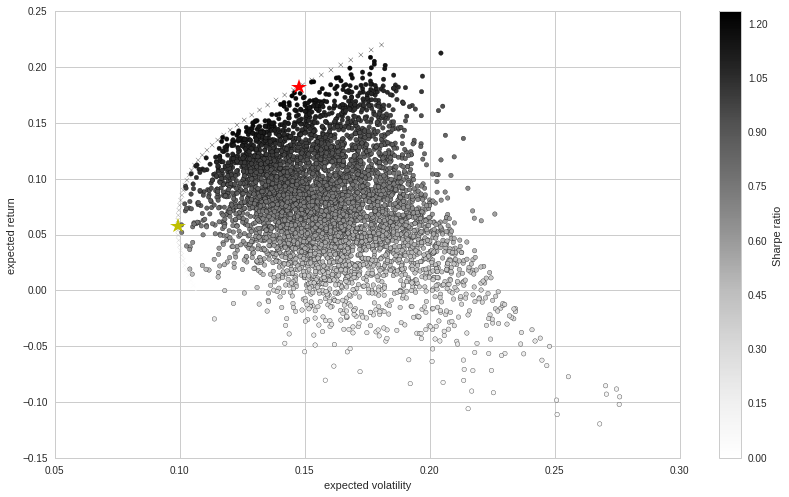

In [18]:
plt.scatter(pvols, prets, c=prets / pvols, marker='o') 
#random portfolio composition 
plt.scatter(tvols, trets,c=trets/tvols, marker='x') 
# efficient frontier
plt.plot(statistics(opt_sharpe['x'],returns)[1], statistics(opt_sharpe['x'],returns)[0], 'r*', markersize=15.8) 
# portfolio with highest Sharpe ratio 
plt.plot(statistics(opt_v['x'],returns)[1], statistics(opt_v['x'],returns)[0],'y*', markersize=15.8) 
# minimum variance portfolio 
plt.grid(True) 
plt.xlabel('expected volatility') 
plt.ylabel('expected return') 
plt.colorbar(label='Sharpe ratio') 

50个叉叉点为有效边界。红星为夏普率最大值的资产组合。黄星为最小波动率的资产组合。

# 资本市场线

考虑这些无风险资产，可以缸若加强投资莉的有效投资机会。基本思路是，投资者首先确定高风险资产的一个有效组合，然后在组合中加入无风险资产。通过调整投资于无风险资产巾的财富比例，有可能实现任何风险.收益均衡性，这些配置位下(风险收益空间中）无风险资产和有效投资组合之间的直线上。
例如：考虑无风险利率，丁$r=0.01$的情况。我们寻找有效边界上切线穿过风险-收益空间上的点$(\sigma_f,r_f) =   ( 0, 1)$的投资组合

为了进行下面的计算，需要一个函数逼近和有效边界的一阶导数，为此，我们使用三次样条捅值

In [19]:
import scipy.interpolate as sci

In [20]:
#对于样条插值，我们只使用有效边界中的投资组合.下面的代码从过去使用的tvols有trets集合中选择这些投资组合:

In [21]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]
#新的对象用于差值
tck = sci.splrep(evols,erets)

In [22]:
def f(x,tck=tck):
    '''Efficient frontier function (splines approximation)'''
    return sci.splev(x,tck,der=0)
def df(x,tck=tck):
    '''First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1) 

我们所寻求的是函数$t(x) = a+b*x$,描述穿过风险-收益空间中无风险资产、与有效边界相切的一条直线

资本市场线的数学条件:
1. $t(x) = a+b*x$

2. $t(0) = r_f$>>>>$a=r_f$

3. $t(x)=f(x)$>>>>  $t(x) = a+b*x = f(x)$

4. $t^{'}=f^{'}(x)$>>>> $b = f^{'}(x)$

In [23]:
#由于我们没有有效边界的封闭公式或者它的一阶导数，所以必须以数值化方式求得公方程组的解
#为此，我们定义一个python函数‘返回给定参数集p=(a，b，x) 下的3个方程式的值
rf=.01
def equations(p, rf=0.01): 
    eq1 = rf - p[0] 
    eq2 = rf + p[1] * p[2] - f(p[2]) 
    eq3 = p[1] - df(p[2]) 
    return eq1, eq2, eq3

In [24]:
#我们提供初始参数，以及equations函数注意，优化的成败可能取决于初始参数化，因此必须小心选择这些参数一一通常需要组合合理的猜测，
#并反复尝试:
from scipy.optimize import fsolve
p0 = [.01,.5,.15]
result = fsolve(equations,p0)
result

array([ 0.01      ,  1.16865194,  0.157565  ])

$a=r_f$合乎预期

In [25]:
np.round(equations(result),6)

array([ 0., -0.,  0.])

3个方程也合乎预期

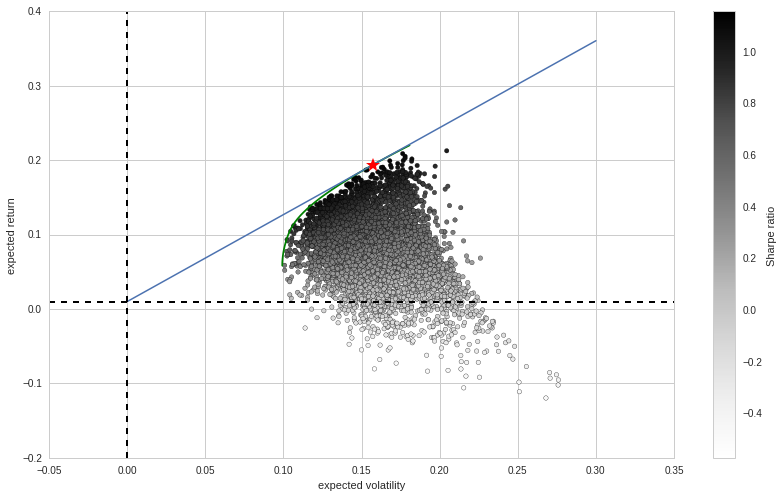

In [26]:
plt.figure()
plt.scatter(pvols,prets,
           c=(prets-.01)/pvols,marker='o')
plt.plot(evols,erets,'g',marker='x')
cx = np.linspace(.0,.3)
plt.plot(cx,result[0]+result[1]*cx,lw=1.5)
plt.plot(result[2], f(result[2]), 'r*', markersize=15.0) #最优投资组合
plt.grid(True) 
plt.axhline(rf,color='k', ls='--',lw=2.0) 
plt.axvline(x=0, ymin=0, linewidth=2, color='k',ls='--')
plt.xlabel('expected volatility') 
plt.ylabel('expected return') 
plt.colorbar(label='Sharpe ratio')

In [27]:
#最优投资组合的权革如下
#约束条件
w0 = np.array([1.0/returns.shape[1]]*returns.shape[1]).reshape(-1,1)
bounds = tuple((0, 1) for i in range(returns.shape[1])) 
cons = ({'type':'eq','fun':lambda x :statistics(x,returns)[0]-f(result[2])},
       {'type':'eq','fun':lambda x :np.sum(x)-1})
opt = minimize(min_func_vol,w0,method='SLSQP',bounds=bounds,constraints=cons,args=(returns,))
opt['x']

array([  3.42606150e-01,   0.00000000e+00,   5.02325791e-01,
         2.73218947e-17,   1.55068059e-01])

#置信区间

In [29]:
#以最优风险资产权重分配作为投资组合的股票权重分配,
#从2014开始到17年期末。投资组合每天的收益率为actual_opt_portfolio_returns：
opt_weights = opt['x'].round(3) # opt_weights是最优风险组合权重 
actual_opt_portfolio_returns = np.sum(returns * opt_weights, axis=1) #axis=1 是按行求和 一行中的每一列相加
actual_opt_portfolio_returns[:5]

2014-01-06 00:00:00+00:00   -0.008738
2014-01-07 00:00:00+00:00    0.000338
2014-01-08 00:00:00+00:00   -0.007740
2014-01-09 00:00:00+00:00   -0.007283
2014-01-10 00:00:00+00:00    0.007416
Freq: C, dtype: float64

In [30]:
#针对投资组合过往3年中的每一天，都观察当天之前的7日年化收益率
#则可以计算出每天考量的7日年化收益率（单利情况）
seven_day_year_returns = 252 * ((actual_opt_portfolio_returns.shift(7) + actual_opt_portfolio_returns.shift(6) + 
                                actual_opt_portfolio_returns.shift(5) + actual_opt_portfolio_returns.shift(4) + 
                                actual_opt_portfolio_returns.shift(3) + actual_opt_portfolio_returns.shift(2) + 
                                actual_opt_portfolio_returns.shift(1)) / 7).dropna()
seven_day_year_returns[:5]

2014-01-15 00:00:00+00:00   -0.422720
2014-01-16 00:00:00+00:00    0.618997
2014-01-17 00:00:00+00:00    0.602654
2014-01-21 00:00:00+00:00    0.366588
2014-01-22 00:00:00+00:00    0.664271
Freq: C, dtype: float64

In [31]:
confidence_range = stats.t.interval(0.99, len(seven_day_year_returns)-1, np.mean(seven_day_year_returns), stats.sem(seven_day_year_returns))
confidence_range

(0.12762174844936525, 0.27292989631249043)

置信度为0.99时，7日年化收益率均值置信区间为 （0.12，0.27）